# XRoration (XGate) - HGQ + hls4ml

## Configuration

Fidelity computation is computation intensive (slow).

In [1]:
FIDELITY_ENABLED = True

Parameters are stored in a shared script.

In [2]:
from parameters import *

Enable seeding for reproducibility of the training.

## Library

In [3]:
import os
import numpy as np
import pandas as pd

import sys
sys.path.append('..')

from utils.helpers import *

# Disable some console warnings
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Check GPU

## Dataset

### Load

In [4]:
x_train = np.load('./data/xrotation/{}/x_train.npy'.format(CSV_CONFIG), allow_pickle=True)
x_val = np.load('./data/xrotation/{}/x_val.npy'.format(CSV_CONFIG), allow_pickle=True)
x_test = np.load('./data/xrotation/{}/x_test.npy'.format(CSV_CONFIG), allow_pickle=True)
y_train = np.load('./data/xrotation/{}/y_train.npy'.format(CSV_CONFIG), allow_pickle=True)
y_val = np.load('./data/xrotation/{}/y_val.npy'.format(CSV_CONFIG), allow_pickle=True)
y_test = np.load('./data/xrotation/{}/y_test.npy'.format(CSV_CONFIG), allow_pickle=True)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

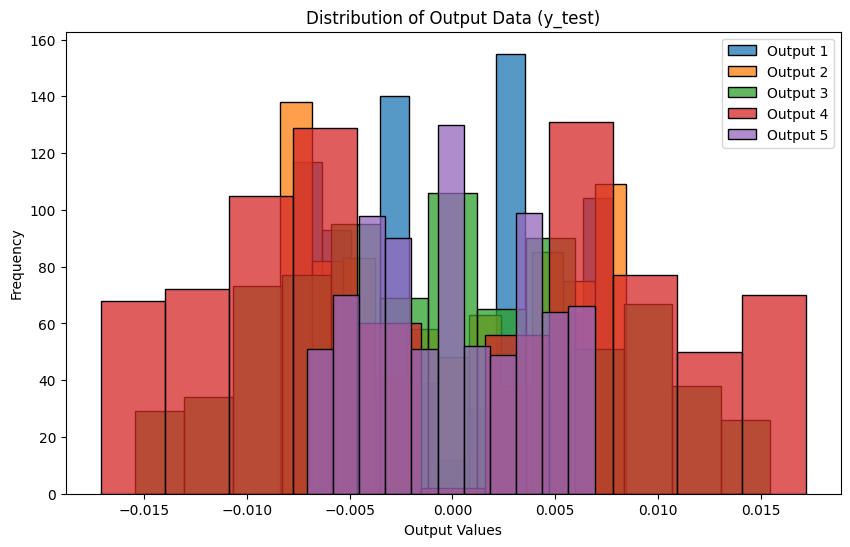

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
for i in range(5):  # Assuming y_test has a shape (n_samples, 20)
    sns.histplot(y_test[:, i], kde=False, label=f'Output {i+1}')
plt.title('Distribution of Output Data (y_test)')
plt.xlabel('Output Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
N_ANGLES = x_train.shape[1]
N_PARAMS = y_train.shape[1]

In [8]:
print('---------------------------------------')
print('- Pulse parameters (y) #', N_PARAMS) # ASSUMING 1 BETA VALUE (ANGLE ALONG X AXIS)
print('- Gate parameters  (x) #', N_ANGLES) # ASSUMING 1 BETA VALUE (ANGLES ALONG X AXIS)
print('---------------------------------------')

---------------------------------------
- Pulse parameters (y) # 5
- Gate parameters  (x) # 1
---------------------------------------


## MLP

### Load Keras Model

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

In [10]:
best_model_file = PREFIX + '/best_keras_model.h5'
def sine_activation(x):
    return tf.math.sin(x)
model = tf.keras.models.load_model(best_model_file, custom_objects={'sine_activation': sine_activation})
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='mean_squared_error',
    metrics=['mean_squared_error'])

In [11]:
model_id_qkeras = MODEL_ID_PREFIX + get_basic_id(model)
print(model_id_qkeras)

smallMLP_1x4x5


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc0 (Dense)                 (None, 4)                 8         
                                                                 
 relu0 (Activation)          (None, 4)                 0         
                                                                 
 fc1 (Dense)                 (None, 5)                 25        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [13]:
for layer in model.layers:
    print(layer.get_config(), layer.get_weights())

{'name': 'fc0', 'trainable': True, 'dtype': 'float32', 'units': 4, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'LecunUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[ 0.12171188,  0.6534984 ,  0.7369929 , -0.00512233]],
      dtype=float32), array([-0.00407998, -0.02350409,  0.0097395 ,  0.20433076], dtype=float32)]
{'name': 'relu0', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'} []
{'name': 'fc1', 'trainable': True, 'dtype': 'float32', 'units': 5, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'LecunUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constrai

### Build HGQ Model

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from HGQ import set_default_kernel_quantizer_config, set_default_pre_activation_quantizer_config
from HGQ import HDense, HQuantize
from HGQ.bops import compute_bops, ResetMinMax, FreeBOPs
from HGQ import update_layerconf, create_replica, patch_hls4ml_project
from HGQ.hls4ml_hook import convert_from_hgq_model

In [15]:
ker_q_conf = dict(
        init_bw=30,
        skip_dims=None,
        rnd_strategy='standard_round',
        exact_q_value=True,
        dtype=None,
        bw_clip=(-32, 32),
        trainable=True,
        regularizer=None,
    )

act_q_conf = dict(
    init_bw=30,
    skip_dims=(0,),
    rnd_strategy='auto',  # 'auto': 'floor' for layer without bias, 'standard_round' otherwise
    exact_q_value=False,
    dtype=None,
    bw_clip=(-32, 32),
    trainable=True,
    minmax_record=True,
    regularizer=None,
)

set_default_kernel_quantizer_config(ker_q_conf)
set_default_pre_activation_quantizer_config(act_q_conf)

In [16]:
beta = 0

# The first layer must be quantized, either by using HQuantize or Signature layers.
# The input quantization layer's name must contain 'inp_q' if you want to quantize the input heterogeneously.
# Use only layers provided by HGQ. You can use functional API as well.

hgqmodel = tf.keras.models.Sequential()
hgqmodel.add(HQuantize(beta=beta,
                  input_shape=(1,),
                  name='inp_q',
                  ))
for i, n in enumerate(NEURONS_PER_LAYER):
    hgqmodel.add(HDense(n,
                      activation='relu',
                      beta=beta))

hgqmodel.add(HDense(N_PARAMS,
                   beta=beta))

In [17]:
model_id_hgq = MODEL_ID_PREFIX + get_basic_id(hgqmodel)
print(model_id_hgq)

smallMLP_1x4x5


In [18]:
hgqmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp_q (HQuantize)           (None, 1)                 3         
                                                                 
 h_dense (HDense)            (None, 4)                 18        
                                                                 
 h_dense_1 (HDense)          (None, 5)                 52        
                                                                 
Total params: 73
Trainable params: 67
Non-trainable params: 6
_________________________________________________________________


### Training

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [20]:
best_model_file_hgq = PREFIX + '/best_hgq_model.h5'
last_model_file_hgq = PREFIX + '/last_hgq_model.h5'

Print the kernel quantizer values BEFORE training

In [21]:
for i in range(len(NEURONS_PER_LAYER)+1):
    print(hgqmodel.layers[i+1].kernel_quantizer.fbw)

<tf.Variable 'h_dense/kernel_bw:0' shape=(1, 4) dtype=float32, numpy=array([[30.497677, 30.017807, 31.083902, 33.170746]], dtype=float32)>
<tf.Variable 'h_dense_1/kernel_bw:0' shape=(4, 5) dtype=float32, numpy=
array([[30.943583, 30.428064, 31.604023, 30.403816, 32.71414 ],
       [32.36008 , 35.400105, 35.3594  , 30.360632, 33.22077 ],
       [31.649645, 33.20484 , 30.429113, 32.835712, 32.43334 ],
       [33.01297 , 30.71935 , 30.480875, 30.869287, 32.37967 ]],
      dtype=float32)>


Enable training (`train_and_save`) to overwrite the model file.

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.MeanSquaredError()
hgqmodel.compile(loss = loss, optimizer = opt)

In [23]:
train_and_save = True

In [24]:
history = None
if train_and_save:
    model_checkpoint = ModelCheckpoint(
    filepath=best_model_file_hgq,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    callbacks = [ResetMinMax(), FreeBOPs(), model_checkpoint]
    history = hgqmodel.fit(x_train, y_train, batch_size=128, epochs=10000, validation_data=(x_val, y_val), callbacks=callbacks, verbose=0)
    hgqmodel.save(last_model_file_hgq)

load the best model from now on

In [25]:
hgqmodel.load_weights(best_model_file_hgq)

In [26]:
import copy
import numpy as np
import pandas
import os
import json
import itertools

import csv
import pandas as pd

from parameters import *


def split_length(total_length, max_length):
    '''
    Split a float / int into a list with max_length
    '''
    #print('total_length = ' + str(total_length) + ' max_length = ' + str(max_length))
    if total_length <= max_length:
        output = [total_length]
    else:
        floor = int(total_length // max_length)
        remaining = (total_length - floor * max_length)
        output = [max_length] * floor
        if remaining != 0:
            output += [remaining]
    #print('output = ' + str(output))
    return(output)


def split_list(input_list, max_length):
    '''
    Split a list into a list of lists with max_length
    '''
    length_list = split_length(len(input_list), max_length)
    output = []
    start_id = 0
    for le in length_list:
        output += [input_list[start_id: start_id + le]]
        start_id += le
    #print('splitlist first value len = ' + str(len(output[0])))
    return(output)


import concurrent.futures as cf
import multiprocessing

try:
    from tqdm import tqdm
    imported_tqdm = True
except (ImportError, ModuleNotFoundError):
    imported_tqdm = False


def parallel_run(func,
                 run_list,
                 n_workers,
                 func_args=(),
                 func_kwargs={},
                 input_as_kwargs=False,
                 processor_no_limited=False,
                 use_tqdm=False,
                 thread_pool=False):
    '''
    Parameters
    ----------
    func                    : function
    run_list                : list
    n_workers               : int
    func_args               : tuple, optional
    func_kwargs             : dict, optional
    input_as_kwargs         : {True, False (default)}, optional
    processor_no_limited    : {True, False (default)}, optional
    use_tqdm                : {True, False (default)}, optional
    thread_pool             : {True, False (default)}, optional
    '''
    run_list_t = run_list

    if processor_no_limited:
        n_workers_use = min(multiprocessing.cpu_count(), n_workers)
    else:
        n_workers_use = n_workers
    n_workers_use = min(n_workers, len(run_list_t))

    u_tqdm = False
    if use_tqdm:
        if imported_tqdm:
            u_tqdm = True
        else:
            warnings.warn('\'tqdm\' not installed.')

    retry_id_list = []
    if n_workers_use == 1:
        if u_tqdm:
            if input_as_kwargs:
                result = [func(*func_args, **x, **func_kwargs)
                          for x in tqdm(run_list_t)]
            else:
                result = [func(x, *func_args, **func_kwargs)
                          for x in tqdm(run_list_t)]
        else:
            if input_as_kwargs:
                result = [func(*func_args, **x, **func_kwargs)
                          for x in run_list_t]
            else:
                result = [func(x, *func_args, **func_kwargs)
                          for x in run_list_t]
    else:
        if not thread_pool:
            ex = cf.ProcessPoolExecutor(max_workers=n_workers_use)
        else:
            ex = cf.ThreadPoolExecutor(max_workers=n_workers_use)

        if input_as_kwargs:
            job_list = [ex.submit(func, *func_args, **x, **func_kwargs)
                        for x in run_list_t]
        else:
            job_list = [ex.submit(func, x, *func_args, **func_kwargs)
                        for x in run_list_t]

        if u_tqdm:
            tqdm_kwargs = {
                'total': len(job_list),
                'unit_scale': True
            }
            for f in tqdm(cf.as_completed(job_list), **tqdm_kwargs):
                pass
        ex.shutdown(wait=True)

        result = [0] * len(job_list)
        for j, job in enumerate(job_list):
            try:
                result[j] = job.result()
            except Exception as e:
                msg = 'item ' + str(j) + ' with error: ' + str(e)
                raise RuntimeError(msg)
    return(result)

In [27]:
def get_xgate_infidelity_individual(
    x, y, 
    config_template=CONFIG_TEMPLATE_JSON, 
    pulse_data_path='/tmp/xgate.csv',
    output_objf_path='/tmp/xgate_fidelity.csv',
    cleanup=True, 
    verbose=False):
    
    BASE_DIR = '../../'
      
    with open(pulse_data_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1).values)
    
    if verbose:
        !cd $BASE_DIR && julia check_RX_pulse_objective_function.jl \
            --config_path $config_template \
            --pulse_data_path $pulse_data_path \
            --output_objf_path $output_objf_path
    else:
        !cd $BASE_DIR && julia check_RX_pulse_objective_function.jl \
            --config_path $config_template \
            --pulse_data_path $pulse_data_path \
            --output_objf_path $output_objf_path > /dev/null

    infidelity_data =  pd.read_csv(output_objf_path, header=None).abs()
    
    if cleanup:
        !rm -f $pulse_data_path
        !rm -f $output_objf_path
    
    return infidelity_data

In [28]:
import random
hash_id = random.getrandbits(32)

# Get infiledilty values of each value in x_values using multithreading
def get_xgate_infidelity_parallel(x_values, y_values, n_workers=1, max_length = 10000):
    x_values_split = split_list(x_values, max_length)
    y_values_split = split_list(recover_original_structure(y_values), max_length)
    run_list = []
    for j, val_in in enumerate(zip(x_values_split, y_values_split)):
        x, y = val_in
        run_list.append(dict(
            x=x,
            y=y,
            pulse_data_path=os.path.join('/tmp', 'xgate_{j}.csv'.format(j=j)),
            output_objf_path=os.path.join('/tmp', 'xgate_fidelity_{j}.csv'.format(j=j)))
        )
    #print(run_list)
    infidelities_raw_list = parallel_run(
        func=get_xgate_infidelity_individual,
        run_list=run_list,
        n_workers=n_workers,
        input_as_kwargs=True,
        use_tqdm=False)
    infidelities_list = [fr.to_numpy().transpose()[0] for fr in infidelities_raw_list]
    infidelities = np.hstack(infidelities_list)

    angles = x_values
    return angles, infidelities

# Wrapper function to allow calling the get_xgate_infidelity_parallel function only once per batch
def infidelity_loss_parallelized(x, y_preds, y_orig):
    num_weights = y_preds.shape[0]
    batch_size = y_preds.shape[1]
    num_outputs = y_preds.shape[2]
    
    #print("num_weights = " + str(num_weights))
    #print("batch_size = " + str(batch_size))
    #print("num_outputs = " + str(num_outputs))
    
    #x = tf.repeat(x, y_preds.shape[0], axis=0)
    
    # Tile x for each of the epsilon added weights
    # The +1 is for the original predictions
    x = tf.tile(x, [num_weights+1, 1])
    # Expand the 3d tensor to 2d to be passable to the infidelity calculator
    y_preds = tf.reshape(y_preds, (num_weights*batch_size, num_outputs))
    
    # Concat the original and epsilon added predictions with the end having the original values
    y_preds = tf.concat([y_preds, y_orig], axis=0)
    
    #print("x shape = " + str(x.shape))
    #print("y_preds shape = " + str(y_preds.shape))
    
    # Get each of the infidelity values for each of the 20(num_outputs) sized vectors in y_preds
    angles, infidelities = get_xgate_infidelity_parallel(x, y_preds, n_workers=32, max_length=40000)
    
    # Take the mean of the last "batch_size" values that are from the original, unmodified weights
    infid_before = tf.reduce_mean(infidelities[-batch_size:])

    #print('infid_before check = ' + str(infid_before.numpy()))
    
    # Reshape the infidelities back so each epsilon perturbed weight's infidelity can be gotten
    infidelities = tf.reshape(infidelities[:-batch_size], (num_weights, batch_size))
    #print('infidelities = ' + str(infidelities))
    infid_y_pred_eps = tf.reduce_mean(infidelities, axis=1, keepdims=True)
    infid_y_pred_eps = tf.squeeze(infid_y_pred_eps, axis=-1)
    #print(infid_y_pred_eps.shape)
    
    return tf.cast(infid_y_pred_eps, tf.float32), tf.cast(infid_before, tf.float32)

Train over 1-fidelity (infidelity) as cost function:

In [29]:
# Calculates gradients 
def infid_grad(x, model, epsilon=1e-7):
    x = tf.cast(x, tf.float32)
    y_pred = model(x)

    y_pred_after_all = []
    # Keep original values so as to revert the models trainable variables after each epsilon modification
    original_values = [v.numpy().copy() for v in model.trainable_variables]
    indices_all = []

    # Apply epsilon perturbation to each weight/bias one at a time
    for i in range(len(model.trainable_variables)):
        variable = model.trainable_variables[i]
        shape = tuple(variable.shape)

        for indices in np.ndindex(shape):
            variable.assign_add(tf.tensor_scatter_nd_update(tf.zeros(shape), [list(indices)], [epsilon]))
            y_pred_after_all.append(model(x))
            indices_all.append((i,) + indices)
            # Revert back to the original weight
            variable.assign(tf.convert_to_tensor(original_values[i], dtype=tf.float32))

    #print("y_pred_after_all shape = " + str(tf.stack(y_pred_after_all).shape))
    # Calculate infidelties of both the perturbed weights and the original model
    infid_after_all, infid_before = infidelity_loss_parallelized(x, tf.stack(y_pred_after_all), y_pred)
    #print(tf.stack(y_pred_after_all).shape)
    grads = [tf.zeros_like(v) for v in model.trainable_variables]
    #print('grads.shape = ' + str(model.trainable_variables))
    
    #print(infid_after_all)
    # Update the gradients by seeing the impact of the epsilon perturbation to each of the models weights 
    for (i, *indices), infid_after in zip(indices_all, infid_after_all):
        grad = (infid_after - infid_before) / epsilon
        #print('grad = ' + str(grad))
        grads[i] = tf.tensor_scatter_nd_update(grads[i], [indices], [grad])

    return grads, infid_before

def compute_validation_loss(x_val):
    y_preds = hgqmodel(x_val, training=False)
    val_loss = get_xgate_infidelity_individual(x_val, recover_original_structure(y_preds),
                                      pulse_data_path='/tmp/xgate_{:x}.csv'.format(hash_id),
                                      output_objf_path='/tmp/xgate_fidelity_{:x}.csv'.format(hash_id))
    return val_loss.mean().values[0]

# Define your model
# For now loading the best available model
hgqmodel.load_weights(best_model_file_hgq)

# Define an optimizer
optimizer = tf.keras.optimizers.Adam()

# Define a metric to track the loss during training
loss_metric = tf.keras.metrics.Mean()

# Define a training step function
def train_step(x, y):
    # Compute the gradients of the trainable variables with respect to the loss
    grads, loss = infid_grad(x, hgqmodel)
    # Update the trainable variables using the optimizer
    optimizer.apply_gradients(zip(grads, hgqmodel.trainable_variables))
    # Update the loss metric
    loss_metric(loss)

if False:
    # Define a ModelCheckpoint callback
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=best_model_file_hgq,  # Path to save the model
        monitor='val_loss',  # The metric to monitor
        mode='min',  # The direction to improve
        save_best_only=True)  # Save only the best model
    model_checkpoint_callback.set_model(hgqmodel)
    
    val_loss = compute_validation_loss(x_val)
    print(f"validation loss before finetune = {val_loss}")
    # Save the model at the end of the epoch
    model_checkpoint_callback.on_epoch_end(0, logs={'val_loss': val_loss})
    # Train the model for some epochs
    for epoch in range(1,20):
        # Reset the loss metric at the start of each epoch
        loss_metric.reset_states()
        # Iterate over the batches of data
        i = 0
        for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128):
            # Perform a training step
            train_step(x_batch, y_batch)
            print("batch step " + str(i))
            i = i+1
        # Calculate validation loss after training in each epoch
        val_loss = compute_validation_loss(x_val)
        # Save the model at the end of the epoch
        model_checkpoint_callback.on_epoch_end(epoch, logs={'val_loss': val_loss})
        # Print the mean loss for this epoch
        print(f"Epoch {epoch + 1}: mean loss = {loss_metric.result()}, validation loss = {val_loss}")


In [30]:
hgqmodel.load_weights(best_model_file_hgq)

Print the kernel quantizer values AFTER training

In [31]:
for i in range(len(NEURONS_PER_LAYER)+1):
    print(hgqmodel.layers[i+1].kernel_quantizer.fbw)

<tf.Variable 'h_dense/kernel_bw:0' shape=(1, 4) dtype=float32, numpy=array([[30.494963, 30.015028, 31.084753, 32.      ]], dtype=float32)>
<tf.Variable 'h_dense_1/kernel_bw:0' shape=(4, 5) dtype=float32, numpy=
array([[30.944935, 30.426096, 31.604023, 30.405922, 32.      ],
       [32.      , 32.      , 32.      , 30.35756 , 32.      ],
       [31.649645, 32.      , 30.427128, 32.      , 32.      ],
       [32.      , 30.719288, 30.480875, 30.86955 , 32.      ]],
      dtype=float32)>


In [32]:
for layer in hgqmodel.layers:
    print(layer.get_config(), layer.get_weights())

{'name': 'inp_q', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 1)} [array([[30.]], dtype=float32), 0.0, 0.0]
{'name': 'h_dense', 'trainable': True, 'dtype': 'float32', 'units': 4, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[-0.38681266, -0.68360823,  0.09061659, -0.01975368]],
      dtype=float32), array([ 0.00605737, -0.00923408, -0.2846997 ,  0.05149731], dtype=float32), array([[30.494963, 30.015028, 31.084753, 32.      ]], dtype=float32), array([[30., 30., 30., 30.]], dtype=float32), 0.0, 3762.0]
{'name': 'h_dense_1', 'trainable': True, 'dtype': 'float32', 'units': 5, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None

### hls4ml

In [33]:
import hls4ml
import matplotlib.pyplot as plt

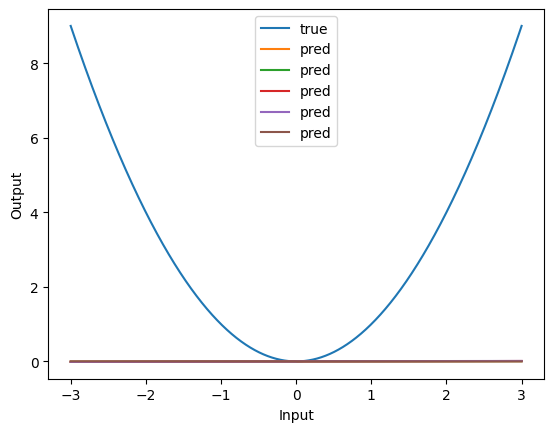

In [34]:
x0 = np.linspace(-3,3,2000).astype(np.float32)
x0 = x0.reshape(-1, 1)
yp = hgqmodel.predict(x0, batch_size=128, verbose=0) # type: ignore

plt.axes(xlabel='Input', ylabel='Output')
plt.plot(x0, x0**2, label='true')
plt.plot(x0, yp, label='pred')
plt.legend()
plt.show()

In [35]:
compute_bops(hgqmodel, x0, bsz=1000)

inp_q: 0.0
h_dense: 3102.0
h_dense_1: 10648.0


13750.0

In [36]:
model_hls = convert_from_hgq_model(
    hgqmodel,
    'hls4ml_prj',
    part='xczu49dr-ffvf1760-2-e-es1',
    clock_period=5,
    bias_accum=None
)

Interpreting Sequential
Topology:
Layer name: inp_q, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: h_dense, layer type: Dense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: h_dense_1, layer type: Dense, input shapes: [[None, 4]], output shape: [None, 5]


/home/mb4989/miniconda3/envs/ml4qcontrol-env6/lib/python3.10/site-packages/HGQ/quantizer.py:230: RuntimeWarning: invalid value encountered in cast
  return int_bits.astype(np.int8), fp_bits.astype(np.int8), kn.astype(np.int8)


Interpreting Sequential
Topology:
Layer name: inp_q, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: h_dense, layer type: Dense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: h_dense_1, layer type: Dense, input shapes: [[None, 4]], output shape: [None, 5]
Creating HLS model


In [37]:
model_hls.compile()

Writing HLS project
Done


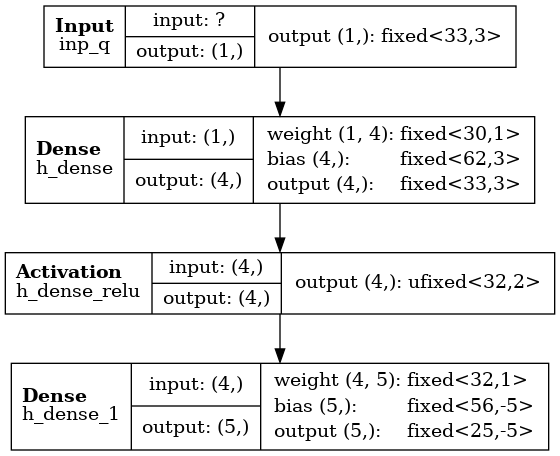

In [38]:
hls4ml.utils.plot_model(model_hls, show_shapes=True, show_precision=True, to_file=None)

### Evaluation

Although we may plot and print many metrics, we focus only on **Mean Squared Error (MSE).**

Plot training history. (Not needed if no retraining of HGQ model is done)

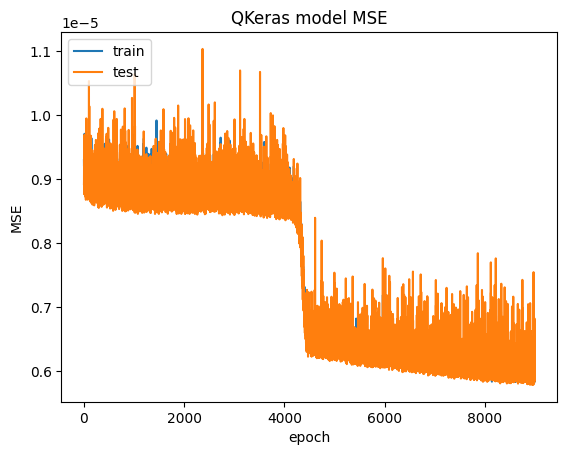

In [39]:
from utils.metrics import plot_metrics

if history:
    plot_metrics(PREFIX,
                 framework='QKeras',
                 save=train_and_save,
                 show_all=False, # show MSLE and MAPE, in addition to MSE
                 history=history)

Print metrics.

In [40]:
from utils.metrics import hls4ml_evaluate

def eval_local_mse(a, b):
    assert(len(a)==len(b))
    M=len(a)
    accum = 0
    for i in range(len(a)):
        accum += (a[i]-b[i])**2
    return accum/len(a)

def hls4ml_evaluate(model, x_test, Y_test):
    import numpy as np
    assert(len(x_test)==len(Y_test))
    N=len(x_test)
    accum = 0
    for i in range(N):
        expected = Y_test[i:i+1][0]
        predicted = model.predict(np.ascontiguousarray(x_test[i]))
        accum += eval_local_mse(expected, predicted)
    return accum / len(x_test)

In [41]:
mse = model.evaluate(x_test, y_test)

26/26 [==============================] - 0s 826us/step - loss: 1.1061e-05 - mean_squared_error: 1.1061e-05


In [42]:
hgqmse = hgqmodel.evaluate(x_test, y_test)

26/26 [==============================] - 1s 16ms/step - loss: 5.7557e-06


In [43]:
hmse = hls4ml_evaluate(model_hls, x_test, y_test)
print(hmse)

2.6983459037578272e-05


In [44]:
y_keras = model.predict(x_test)

26/26 [==============================] - 0s 653us/step


In [45]:
y_hgq = hgqmodel.predict(x_test)

26/26 [==============================] - 0s 925us/step


In [46]:
y_hls = model_hls.predict(x_test)

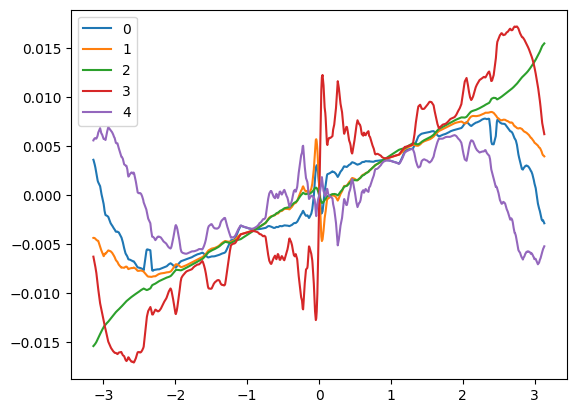

In [47]:
order = np.argsort(x_test[:,0])

for i in range(5):
    plt.plot(x_test[order,0], y_test[order,i], label=str(i))
plt.legend()
plt.show()

Save metrics values to file for future reference.

In [48]:
import random
hash_id = random.getrandbits(32)

if FIDELITY_ENABLED:
    xgate_fidelity_hgq = get_xgate_fidelity(x_test,
                                               recover_original_structure(y_hgq),
                                               config_template=CONFIG_TEMPLATE_JSON,
                                               pulse_data_path='/tmp/xgate_{:x}.csv'.format(hash_id),
                                               output_objf_path='/tmp/xgate_fidelity_{:x}.csv'.format(hash_id))
else:
    xgate_fidelity_hgq = None

In [49]:
if FIDELITY_ENABLED:
    xgate_fidelity_hls = get_xgate_fidelity(x_test,
                                               recover_original_structure(y_hls),
                                               config_template=CONFIG_TEMPLATE_JSON,
                                               pulse_data_path='/tmp/xgate_{:x}.csv'.format(hash_id),
                                               output_objf_path='/tmp/xgate_fidelity_{:x}.csv'.format(hash_id))
else:
    xgate_fidelity_hls = None

Save metrics values to file for future reference.

In [50]:
with pd.option_context('display.float_format', '{:0.12f}'.format):
    data1 = pd.DataFrame([["HGQ", hgqmse, "", "", xgate_fidelity_hgq]], columns=["", "MSE", "MSLE", "MAPE", "Fidelity"])
    data2 = pd.DataFrame([["hls4ml", hmse, "", "", xgate_fidelity_hls]], columns=["", "MSE", "MSLE", "MAPE", "Fidelity"])
    display(data1)
    display(data2)

,,MSE,MSLE,MAPE,Fidelity
0,HGQ,0.000005755694,,,0.998582823372


,,MSE,MSLE,MAPE,Fidelity
0,hls4ml,0.000026983459,,,0.758987160118


Save metrics values to file for future reference.

In [51]:
metrics_filename = PREFIX + '/metrics.csv'

# You can disable the writing if necessary.
write_metrics_csv = True

In [52]:
from utils.metrics import write_metrics
if write_metrics_csv:
    write_metrics(metrics_filename, 'HGQ', model_id_hgq, hgqmse, "", "", xgate_fidelity_hgq)
    write_metrics(metrics_filename, 'hls4ml', model_id_hgq, hmse, "", "", xgate_fidelity_hls)

In [53]:
from utils.metrics import print_metrics
print_metrics(metrics_filename)

,Date,Framework,ID,MSE,MSLE,MAPE,Fidelity
0,27/10/2023 17:37:49,QKeras,smallMLP_1x12x8x16x12x8x20,0.000014923722,NaN,NaN,0.999936037016
1,28/10/2023 02:19:25,QKeras,smallMLP_1x12x8x16x12x8x20,0.000014923722,NaN,NaN,0.999936037016
2,28/10/2023 02:19:25,HGQ,smallMLP_1x12x8x16x12x8x20,NaN,NaN,NaN,0.072114244857
3,31/10/2023 04:22:00,QKeras,smallMLP_1x12x8x16x12x8x20,0.000014923722,NaN,NaN,0.999936037016
4,31/10/2023 04:22:00,HGQ,smallMLP_1x12x8x16x12x8x20,NaN,NaN,NaN,0.489870185500
...,...,...,...,...,...,...,...
107,10/12/2023 21:22:21,hls4ml,smallMLP_1x4x5,0.000066320247,NaN,NaN,0.735781466289
108,10/12/2023 21:38:26,HGQ,smallMLP_1x4x5,0.000003179895,NaN,NaN,0.999951367404
109,10/12/2023 21:38:26,hls4ml,smallMLP_1x4x5,0.000066320247,NaN,NaN,0.735781466289
110,10/12/2023 21:52:28,HGQ,smallMLP_1x4x5,0.000005755694,NaN,NaN,0.998582823372
